# **WFLOW: PRODUCTS RELATED TO DIGITAL ELEVATION MODEL**

## *PACKAGES*


In [1]:
include(raw"E:\JOE3\MAIN\MODELS\WFLOW\WflowDataJoe\WflowRaster.jl\src\GeoRaster.jl")

using  Geomorphometry, Rasters, Shapefile, GeoTIFF, ArchGDAL, GeoFormatTypes, GeoArrays, Extents
using CairoMakie, GLMakie

CairoMakie.activate!()


## *PARAMETERS*

In [ ]:
# ======= PATHS =======
Path_Root       = raw"E:\JOE3\MAIN\MODELS\WFLOW\DATA\Timoleague"
Path_Input      = "InputGis"
Path_Output     = "OutputJulia"
Path_Temporary  = "Temporary"

# ====== FILES NAME =======
# == Input ==
Name_Dem          = "Timoleague_DTM_1m.tif"
Temporary_Dem      = "Temporary_DEM.tif"

# == Output ==
Output_Dem         = "Timoleague_DEM.tif"
Output_Slope       = "Slope.tiff"
Input_Outlet       = "Timoleague_Outlet.shp"
Output_Outlet      = "Timololeague_Outlet.tiff"

Path_Input_Dem     = joinpath(Path_Root, Path_Input, Name_Dem)
Path_Temporary_Dem = joinpath(Path_Root, Path_Input, Temporary_Dem)
Path_Output_Dem    = joinpath(Path_Root, Path_Output, Output_Dem)

Crs             = 29902    # [-] This is the default projection TM65 / Irish Grid
ΔX              = 5        # [m] Gridded spatial resolution

ResampleMethod_1 = :min
ResampleMethod_2 = :cubicspline



:cubicspline

## **DEM OFFICIAL GRID SIZE**

	https://rafaqz.github.io/Rasters.jl/dev/api#Rasters.resample-Tuple
method: A Symbol or String specifying the method to use for resampling. From the docs for gdalwarp:

**:near:** nearest neighbour resampling (default, fastest algorithm, worst interpolation quality).
:bilinear: bilinear resampling.
:cubic: cubic resampling.
:cubicspline: cubic spline resampling.
:lanczos: Lanczos windowed sinc resampling.
:average: average resampling, computes the weighted average of all non-NODATA contributing pixels. rms root mean square / quadratic mean of all non-NODATA contributing pixels (GDAL >= 3.3)
:mode: mode resampling, selects the value which appears most often of all the sampled points.
:max: maximum resampling, selects the maximum value from all non-NODATA contributing pixels.
:min: minimum resampling, selects the minimum value from all non-NODATA contributing pixels.
:med: median resampling, selects the median value of all non-NODATA contributing pixels.
:q1: first quartile resampling, selects the first quartile value of all non-NODATA contributing pixels.
:q3: third quartile resampling, selects the third quartile value of all non-NODATA contributing pixels.
:sum: compute the weighted sum of all non-NODATA contributing pixels (since GDAL 3.1)

## Resamplling

E:\JOE3\MAIN\MODELS\WFLOW\DATA\Timoleague\OutputJulia\Timoleague_DEM.tif
Bands = 1
Crs = 29902
ΔX = 5.0
ΔY = 5.0
N_Width  = 921
N_Height = 571
Coord_X_Left = 143100.001, Coord_X_Right = 147700.001
Coord_Y_Top = 42625.008, Coord_Y_Bottom = 39775.008


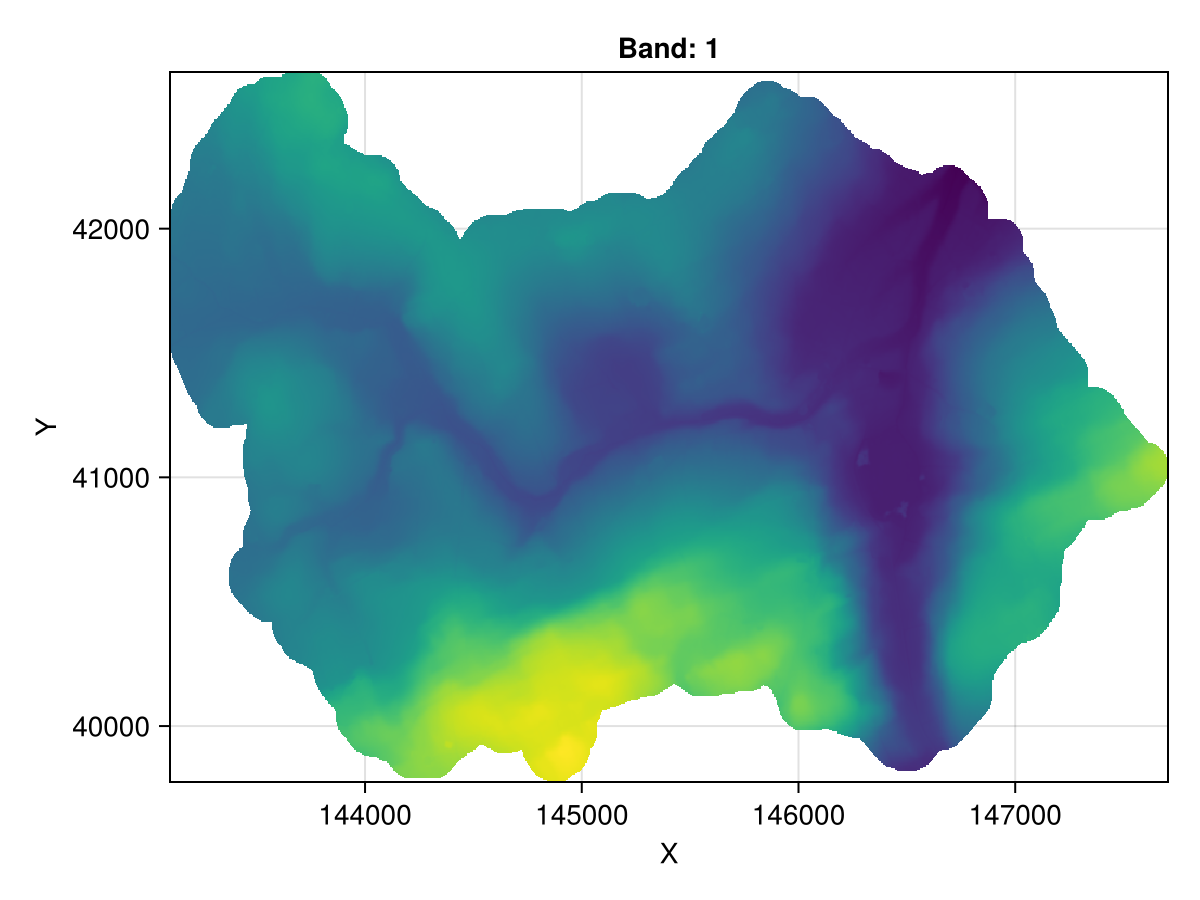

In [11]:
include(raw"E:\JOE3\MAIN\MODELS\WFLOW\WflowDataJoe\WflowRaster.jl\src\GeoRaster.jl")
using .geoRaster

# Reading data
	Dem_Raw = Rasters.Raster(Path_Input_Dem)

# Resample Dem in 2 steps
	Crs_GeoFormat = GeoFormatTypes.convert(WellKnownText, EPSG(Crs))

	Dem_Resample₀ = Rasters.replace_missing(Dem_Raw, missingval=NaN)

	Dem_Resample₁ = Rasters.resample(Dem_Resample₀; res=min(ΔX, 3), method=ResampleMethod_1, crs=Crs_GeoFormat)

	Dem_Resample = Rasters.resample(Dem_Resample₁; res=ΔX, method=ResampleMethod_2, crs=Crs_GeoFormat)

# Writting the output
	Rasters.write(Path_Output_Dem, Dem_Resample; ext=".tiff", missingval= NaN, force=true, verbose=true)

# Getting the metadata
	metadatas = geoRaster.RASTER_METADATA(Path_Output_Dem; Verbose=true);

# Plotting
	Makie.plot(Dem_Resample)

# # Dem_Resample = Rasters.resample(Dem_Resample; res=ΔX, method=:lanczos, to=metadata.Extent, crs=metadata.Crs_GeoFormat)

# # Dem_Resample = Rasters.aggregate(locus=Rasters.Center(), Dem_Raw, (Y(ΔX), X(ΔX)); skipmissingval=true)

# # E:\JOE3\MAIN\MODELS\WFLOW\DATA\Timoleague\OutputJulia\Timoleague_DEM.tif


## COMPUTING SLOPE

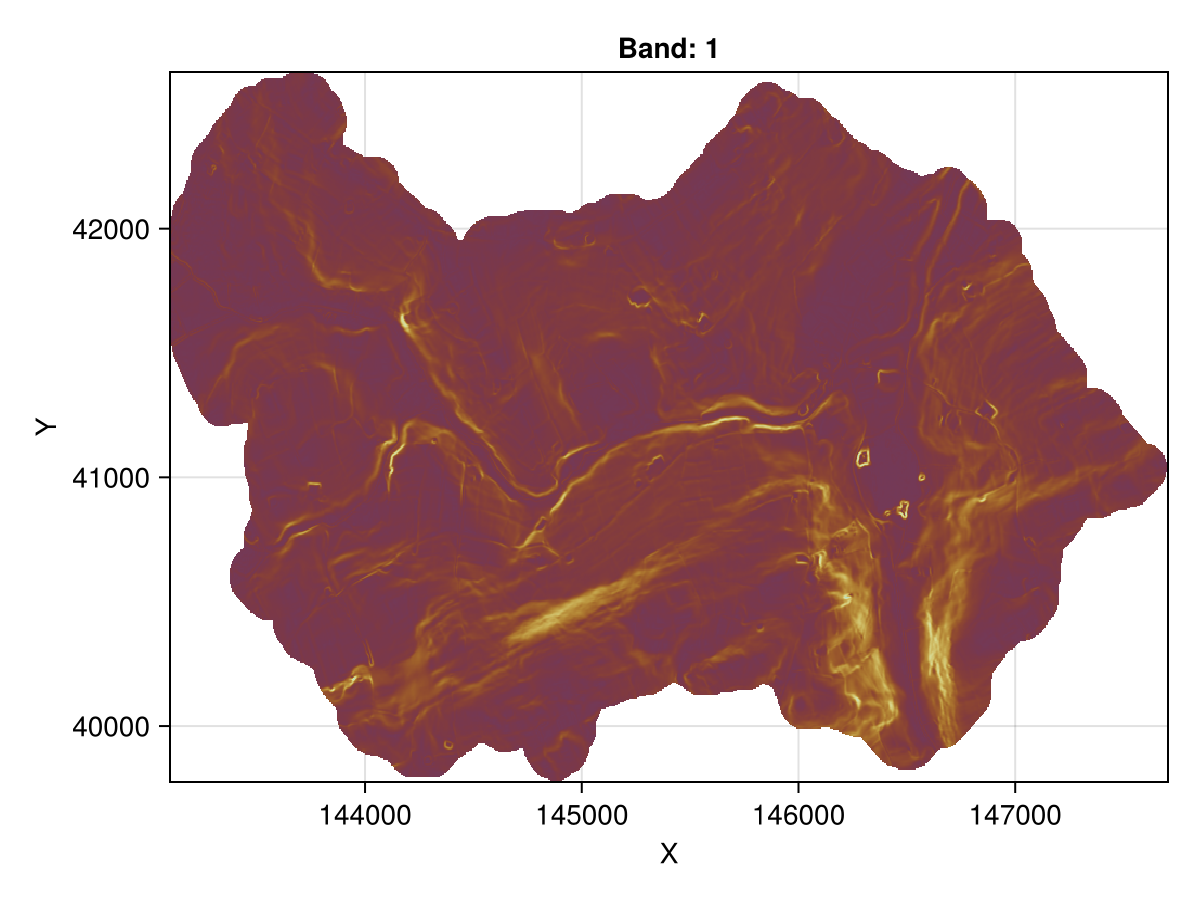

In [10]:

Path_Output_Slope    = joinpath(Path_Root, Path_Output, Output_Slope)

Slope = Geomorphometry.slope(Dem_Resample; method=Horn())

Rasters.write(Path_Output_Slope, Slope; ext=".tiff", force=true, verbose=true, missingval= NaN)

CairoMakie.heatmap(Slope ; colormap=:romaO, colorrange=(0, 60))


## OUTLETS STATION

In [ ]:

Path_Input_Outlet  = joinpath(Path_Root, Path_Input, Input_Outlet)

Path_Output_Outlet = joinpath(Path_Root, Path_Output, Output_Outlet)
println(Path_Input_Outlet)

# Load the shapefile
	Outlet_Raw = Shapefile.Handle(Path_Input_Outlet)

Outlet = Rasters.rasterize(last, Outlet_Raw; res=ΔX, fill=1, missingval=NaN, crs=metadatas.Crs_GeoFormat, to=Dem_Resample, shape=:point ,progress=true)

Rasters.write(Path_Output_Outlet, Outlet; ext=".tiff", force=true, verbose=true, missingval= NaN)

CairoMakie.heatmap(Outlet ; colormap=:romaO, colorrange=(0, 60))


## RIVER

In [ ]:
Input_River       = "Timoleague_River.shp"
Path_Input_River  = joinpath(Path_Root, Path_Input, Input_River)
Output_River      = "Timololeague_River.tiff"
Path_Output_River = joinpath(Path_Root, Path_Output, Output_River)
println(Path_Input_River)

# Load the shapefile
	River_Raw = Shapefile.Handle(Path_Input_River)

River = Rasters.rasterize(last, River_Raw; res=ΔX, fill=1, missingval=NaN, crs=metadatas.Crs_GeoFormat, to=Dem_Resample, shape=:line ,progress=true)

Rasters.write(Path_Output_River, River; ext=".tiff", force=true, verbose=true, missingval= NaN)

CairoMakie.heatmap(River ; colormap=:romaO, colorrange=(0, 60))


## *Slope of Rivers*

In [ ]:
Output_River_Slope      = "Timololeague_River_Slope.tiff"
Path_Output_River_Slope = joinpath(Path_Root, Path_Output, Output_River_Slope)
println(Path_Output_River_Slope)

RiverSlope = Rasters.mask(Slope; with=River, missingval=NaN)

Rasters.write(Path_Output_River_Slope, RiverSlope; ext=".tiff", force=true, verbose=true, missingval= NaN)

CairoMakie.heatmap(RiverSlope ; colormap=:romaO, colorrange=(0, 60))


## *Width of river*

In [ ]:
Output_River_Width      = "Timololeague_River_Width.tiff"
Path_Output_River_Width = joinpath(Path_Root, Path_Output, Output_River_Slope)
println(Path_Output_River_Width)

P_River_Width = 2.0 # meters

River_Width = River .* P_River_Width

Rasters.write(Path_Output_River_Width, River_Width; ext=".tiff", force=true, verbose=true, missingval= NaN)

CairoMakie.heatmap(River_Width ; colormap=:romaO, colorrange=(0, 60))


## PYTHON

In [ ]:
include(raw"E:\JOE3\MAIN\MODELS\WFLOW\WflowDataJoe\WflowRaster.jl\src\GeoRaster.jl")
using .geoRaster

P_Int=1; P_Float=2.0; P_String=3; P_Vector = [1.0, 2.0, 3.0, 4.0]
P_Int1, P_Float1, P_String1, P_Vector1 = geoRaster.PYTHON_2_JULIA(P_Int, P_Float, P_String, P_Vector)

@show P_Int1, P_Float1, P_String1, P_Vector1

P_Vector1[1]


In [ ]:
include(raw"E:\JOE3\MAIN\MODELS\WFLOW\WflowDataJoe\WflowRaster.jl\src\GeoRaster.jl")
using .geoRaster

Path_Input_Dem     = joinpath(Path_Root, Path_Input, Input_Dem)
Path_Output_Ldd    = joinpath(Path_Root, Path_Output, "Ldd.tiff")

FlowDirection_Array, FlowDirection_Pyflwdir = geoRaster.DEM_2_FLOWDIRECTION(Path_Input_Dem, Path_Output_Ldd)


## LDD D8

In [ ]:
Output_Ldd         = "Ldd.tiff"
Path_Output_Ldd    = joinpath(Path_Root, Path_Output, Output_Ldd)
println(Path_Output_Ldd)

Acc, Ldd = Geomorphometry.flowaccumulation(Dem_Resample; method=D8())

Rasters.write(Path_Output_Ldd, Ldd; ext=".tiff", force=true, verbose=true, missingval= NaN)

CairoMakie.heatmap(log10.(Acc); colormap=:rain)


## DEM -> Slope

## Flow direction from elevation data

## CATCHMENT AREA

In [ ]:
using CondaPkg, PythonCall

Output_Catchment      = "Timololeague_Catchment.tiff"
Path_Output_Catchment = joinpath(Path_Root, Path_Output, Output_Catchment)


# PYTHON